# Image Captioning with RNN

- 기수: 14

- 이름: 어희정

- 작성자: 13기 강승우, 조지성, 한연주

*본 과제 문제는 Stanford CS231n의 Assignment를 기반으로 일부 수정하여 작성되었으며, 동시에 https://github.com/changdaeoh/CS231n 내용을 참고하여 작성되었음을 밝힙니다.*

- Reference: 24-2 RNN+Transformer Assignment / 11기 김정우

본 과제에서는 Vanilla Recurrent Neural Networks (RNN) 구현 및 모델 학습을 통해 Image Captioning Task를 진행합니다.

### 0. Installation and Colab Drive

In [5]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install h5py

### 1. Setting

In [9]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import h5py

import urllib.request
from skimage.io import imread

from PIL import Image
import requests
from io import BytesIO

In [12]:
pwd

'/content'

In [13]:
!mv /content/drive/MyDrive/ColabNotebooks/DSL/utils /content/

Colab 환경에서 실행 시, utils 폴더를 root 디렉토리에 업로드하기 바랍니다!

In [14]:
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.rnn_layers import *
from utils.captioning_solver import CaptioningSolver
from utils.classifiers.rnn import CaptioningRNN
from utils.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from utils.image_utils import image_from_url

In [15]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

### 2. Dataset

본 과제에서는 COCO Dataset을 사용합니다.

해당 데이터셋은 12,000(8000+4000)개의 데이터셋이 각각 5개의 caption과 함께 제공됩니다.

Image Feature는 VGG-16의 fc7을 기준으로 이미 추출된 feature를 사용합니다.

데이터셋의 크기로 인해 따로 zip 파일에 포함하진 않았습니다.

아래 링크를 통해 coco_captioning.zip을 다운받아 압축 해제 후 ./utils/datasets/coco_captioning 폴더로 저장해주세요.

http://cs231n.stanford.edu/coco_captioning.zip

In [17]:
!mv /content/drive/MyDrive/ColabNotebooks/DSL/coco_captioning /content/utils/datasets/

In [21]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/utils/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


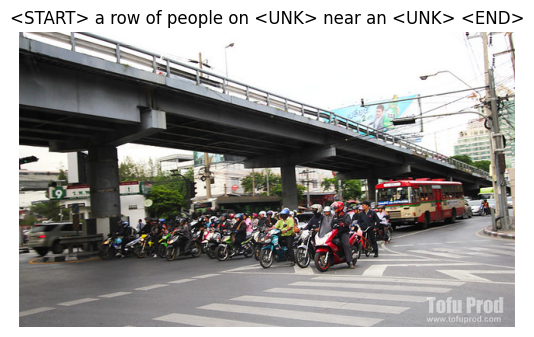

In [22]:
batch_size = 1

def image_from_url(url):
    response = requests.get(url)

    try:
        img = Image.open(BytesIO(response.content))
        return np.array(img)
    except Exception as e:
        raise ValueError(f"Failed to process image from {url}: {e}")

# 나머지 코드는 동일
captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))  # image_from_url 함수가 이제 numpy 배열을 반환
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()


### 3. Recurrent Neural Network

utils/rnn_layers.py에는 RNN 필요한 다양한 layer type들이 저장되어 있음.

utils/classifiers/rnn.py에서는 이러한 layer들을 사용하여 image captioning model을 구현하고 있음.

#### 3.1. Vanilla RNN: Step Forward

아래 rnn_step_forward 함수 구현을 통해 Vanilla RNN의 single timestep을 구현하고자 한다.

In [23]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """Run the forward pass for a single timestep of a vanilla RNN using a tanh activation.

    Inputs:
    - x: Input data for this timestep, of shape (N, D)
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    # affine transform then tanh nonlinearity
    affine = x.dot(Wx) + prev_h.dot(Wh) + b  # shape (N, H)
    next_h = np.tanh(affine)

    # cache values needed for backward (keep as in the hint)
    cache = (x, prev_h, Wx, Wh, next_h)

    return next_h, cache


In [24]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


#### 3.2. Vanilla RNN: Step Backward

아래 rnn_step_forward 함수 구현을 통해 Vanilla RNN의 backward update를 구현하고자 한다.

**TODO**

아래 rnn_step_backward 함수의 각 gradient operation 과정을 rnn_step_forward와 비교하여 수식적으로 미분한 결과를 첨부하시오.

직접 계산한 gradient와 아래 코드의 구현이 일치하는지 확인하시오

[사진으로 첨부]

In [25]:
def rnn_step_backward(dnext_h, cache):
    """Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state, of shape (N, H)
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """

    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    x, prev_h, Wx, Wh, next_h = cache

    dnext_tanh = 1-next_h**2
    dtanh = dnext_h*dnext_tanh  # (N,H)*(N,H) => (N,H)

    db = np.sum(dtanh, axis=0)  # (N,H) => (H,)
    dx = dtanh.dot(Wx.T)        # (N,H)X(H,D) => (N,D)
    dprev_h = dtanh.dot(Wh.T)   # (N,H)X(H,H) => (N,H)
    dWx = x.T.dot(dtanh)        # (D,N)X(N,H) => (D,H)
    dWh = prev_h.T.dot(dtanh)   # (H,N)X(N,H) => (H,H)

    return dx, dprev_h, dWx, dWh, db

In [26]:
np.random.seed(2025)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.3079069982527431e-10
dprev_h error:  2.1405824541349492e-10
dWx error:  4.266807283241945e-09
dWh error:  9.873897099024049e-10
db error:  8.684566415311552e-11


#### 3.3. Vanilla RNN: Forward

앞서 구현한 rnn_step_forward 함수를 적절히 활용하여 아래 rnn_forward 함수를 완성하시오.

In [27]:
def rnn_forward(x, h0, Wx, Wh, b):
    """Run a vanilla RNN forward on an entire sequence of data.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H)
    - cache: List of caches from each timestep (for backward pass)
    """
    N, T, D = x.shape
    H = h0.shape[1]

    h = np.zeros((N, T, H))
    cache = []

    prev_h = h0
    for t in range(T):
        xt = x[:, t, :]                                # (N, D)
        next_h, step_cache = rnn_step_forward(xt, prev_h, Wx, Wh, b)
        h[:, t, :] = next_h                            # 저장
        cache.append(step_cache)                       # backward용 cache
        prev_h = next_h                                # 다음 timestep 입력용

    return h, cache

In [28]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])

print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


#### 3.4. Vanilla RNN: Backward

실제 구체적인 Backward의 구현은 다음과 같습니다. 참고로 코드 확인만 하기 바랍니다.

In [29]:
def rnn_backward(dh, cache):
    """Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)

    NOTE: 'dh' contains the upstream gradients produced by the
    individual loss functions at each timestep, *not* the gradients
    being passed between timesteps (which you'll have to compute yourself
    by calling rnn_step_backward in a loop).

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None

    N, T, H = dh.shape
    dx = np.zeros((N, T, cache[0][2].shape[0]))
    for t in range(T-1,-1,-1):
        if t == T-1:
            dx[:,t,:], dprev_h, dWx, dWh, db = rnn_step_backward(dh[:,t,:], cache[t])
        elif t != 0:
            dx[:,t,:], dprev_h, dWx_m, dWh_m, db_m = rnn_step_backward(dh[:,t,:]+dprev_h, cache[t])
            dWx += dWx_m
            dWh += dWh_m
            db += db_m
        else:
            dx[:,t,:], dh0, dWx_0, dWh_0, db_0 = rnn_step_backward(dh[:,t,:]+dprev_h, cache[t])
            dWx += dWx_0
            dWh += dWh_0
            db += db_0

    return dx, dh0, dWx, dWh, db

In [30]:
N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.2886948265136368e-09
dh0 error:  8.293328820626882e-11
dWx error:  7.892076655855677e-09
dWh error:  2.3359318285014754e-09
db error:  3.4370087535468035e-10


#### 3.5. Word Embedding

NLP Task의 경우, 필연적으로 Word Embedding 과정이 필요합니다.

아래 word_embedding_forward와 word_embedding_backward를 통해 워드 임베딩 과정을 수행하게 되니, 결과를 확인하기 바랍니다.

In [31]:
def word_embedding_forward(x, W):
    """Forward pass for word embeddings.

    We operate on minibatches of size N where
    each sequence has length T. We assume a vocabulary of V words, assigning each
    word to a vector of dimension D.

    Inputs:
    - x: Integer array of shape (N, T) giving indices of words. Each element idx
      of x muxt be in the range 0 <= idx < V.
    - W: Weight matrix of shape (V, D) giving word vectors for all words.

    Returns a tuple of:
    - out: Array of shape (N, T, D) giving word vectors for all input words.
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    out = W[x[:,:]]
    cache = x, W, out

    return out, cache

def word_embedding_backward(dout, cache):
    """Backward pass for word embeddings.

    We cannot back-propagate into the words
    since they are integers, so we only return gradient for the word embedding
    matrix.

    HINT: Look up the function np.add.at

    Inputs:
    - dout: Upstream gradients of shape (N, T, D)
    - cache: Values from the forward pass

    Returns:
    - dW: Gradient of word embedding matrix, of shape (V, D)
    """
    dW = None

    x, W, out = cache
    dW = np.zeros_like(W)

    for i in range(x.shape[0]):
        idx = x[i,:]  # (T,)
        np.add.at(dW, idx, dout[i,:,:])  # dW의 각 토큰들 위치에 upstream grad 누적

    return dW


In [32]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


In [33]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


#### 3.6. Temporal Affine Layer

매 timestep마다 RNN의 hidden vector를 각 단어에 맞는 score로 변환하기 위해, affine function을 필요로 합니다.

temporal_affine_forward와 temporal_affine_backward function의 경우 아래와 같이 주어졌으니 직접 코드를 확인해보기 바랍니다.

In [34]:
def temporal_affine_forward(x, w, b):
    """Forward pass for a temporal affine layer.

    The input is a set of D-dimensional
    vectors arranged into a minibatch of N timeseries, each of length T. We use
    an affine function to transform each of those vectors into a new vector of
    dimension M.

    Inputs:
    - x: Input data of shape (N, T, D)
    - w: Weights of shape (D, M)
    - b: Biases of shape (M,)

    Returns a tuple of:
    - out: Output data of shape (N, T, M)
    - cache: Values needed for the backward pass
    """
    N, T, D = x.shape
    M = b.shape[0]
    out = x.reshape(N * T, D).dot(w).reshape(N, T, M) + b
    cache = x, w, b, out
    return out, cache


def temporal_affine_backward(dout, cache):
    """Backward pass for temporal affine layer.

    Input:
    - dout: Upstream gradients of shape (N, T, M)
    - cache: Values from forward pass

    Returns a tuple of:
    - dx: Gradient of input, of shape (N, T, D)
    - dw: Gradient of weights, of shape (D, M)
    - db: Gradient of biases, of shape (M,)
    """
    x, w, b, out = cache
    N, T, D = x.shape
    M = b.shape[0]

    dx = dout.reshape(N * T, M).dot(w.T).reshape(N, T, D)
    dw = dout.reshape(N * T, M).T.dot(x.reshape(N * T, D)).T
    db = dout.sum(axis=(0, 1))

    return dx, dw, db

In [35]:
# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  1.1530124616524771e-10
dw error:  2.826886262192887e-11
db error:  9.9257220805086e-12


#### 3.7. Temporal Softmax Loss

RNN을 이용한 NLP Task에서는, 우리가 생성한 각 단어에 대한 score와 Ground Truth (GT)를 매 timestep마다 비교하여 loss를 정의합니다.

다만 우리는 서로 다른 길이의 caption들을 사용하기에, NULL 값을 사용하여 빈 부분을 채워주게 되는데, 이 NULL의 경우 모델의 학습에 사용되지 않게 하기 위한 과정이 필요합니다.

RNN의 loss function이 실제로 어떻게 구성되는지 아래 코드를 통해 확인하기 바랍니다.


In [36]:
def temporal_softmax_loss(x, y, mask, verbose=False):
    """A temporal version of softmax loss for use in RNNs.

    We assume that we are making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores for all vocabulary
    elements at all timesteps, and y gives the indices of the ground-truth element at each timestep.
    We use a cross-entropy loss at each timestep, summing the loss over all timesteps and averaging
    across the minibatch.

    As an additional complication, we may want to ignore the model output at some timesteps, since
    sequences of different length may have been combined into a minibatch and padded with NULL
    tokens. The optional mask argument tells us which elements should contribute to the loss.

    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V
    - mask: Boolean array of shape (N, T) where mask[i, t] tells whether or not
      the scores at x[i, t] should contribute to the loss.

    Returns a tuple of:
    - loss: Scalar giving loss
    - dx: Gradient of loss with respect to scores x.
    """

    N, T, V = x.shape

    x_flat = x.reshape(N * T, V)
    y_flat = y.reshape(N * T)
    mask_flat = mask.reshape(N * T)

    probs = np.exp(x_flat - np.max(x_flat, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    loss = -np.sum(mask_flat * np.log(probs[np.arange(N * T), y_flat])) / N
    dx_flat = probs.copy()
    dx_flat[np.arange(N * T), y_flat] -= 1
    dx_flat /= N
    dx_flat *= mask_flat[:, None]

    if verbose:
        print("dx_flat: ", dx_flat.shape)

    dx = dx_flat.reshape(N, T, V)

    return loss, dx

In [37]:
N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])

check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be within 2.2-2.4

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3025089372628367
23.02530059453384
2.294760891654348
dx error:  3.5961413189576796e-08


### 4. Training

실제 학습에 사용되는 모델의 경우 ./utils/classifiers/rnn.py 파일의 CaptioningRNN 클래스를 통해 구현되어 있습니다.

구체적인 코드는 해당 파일을 통해 확인 바라며, 아래와 같이 사용할 수 있습니다.

In [38]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type='rnn',
    dtype=np.float64
)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.832355910027392
expected loss:  9.83235591003
difference:  2.6076918402395677e-12


실제 모델 학습 과정에선 학습을 돕기 위한 여러 설정을 담당하는 solver가 함께 필요합니다.

solver의 경우 ./utils/captioning_solver.py의 CaptioningSolver 클래스를 통해 확인할 수 있습니다.

모델 학습 코드는 아래와 같습니다. 적절히 batch_size와 epoch, learning_rate 등의 config를 수정하여 최종 loss를 0.1 이하로 낮춰보세요!

base dir  /content/utils/datasets/coco_captioning
(Iteration 1 / 100) loss: 80.352078
(Iteration 11 / 100) loss: 37.069464
(Iteration 21 / 100) loss: 16.107737
(Iteration 31 / 100) loss: 5.045242
(Iteration 41 / 100) loss: 1.681010
(Iteration 51 / 100) loss: 0.559640
(Iteration 61 / 100) loss: 0.367736
(Iteration 71 / 100) loss: 0.229804
(Iteration 81 / 100) loss: 0.182448
(Iteration 91 / 100) loss: 0.139582


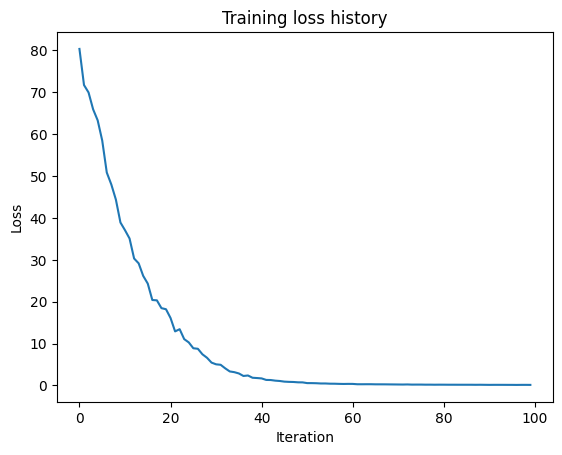

In [49]:
small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
    cell_type='rnn',
    word_to_idx=data['word_to_idx'],
    input_dim=data['train_features'].shape[1],
    hidden_dim=512,
    wordvec_dim=256,
)

small_rnn_solver = CaptioningSolver(
    small_rnn_model, small_data,
    update_rule='adam',
    num_epochs=100,
    batch_size=50,
    optim_config={
     'learning_rate':1e-3,
    },
    lr_decay=1.0,
    verbose=True, print_every=10,
)

small_rnn_solver.train()

# Plot the training losses.
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

### 5. Test

아래와 같이 학습시킨 small_rnn_model의 성능을 직접 확인해 볼 수도 있습니다!

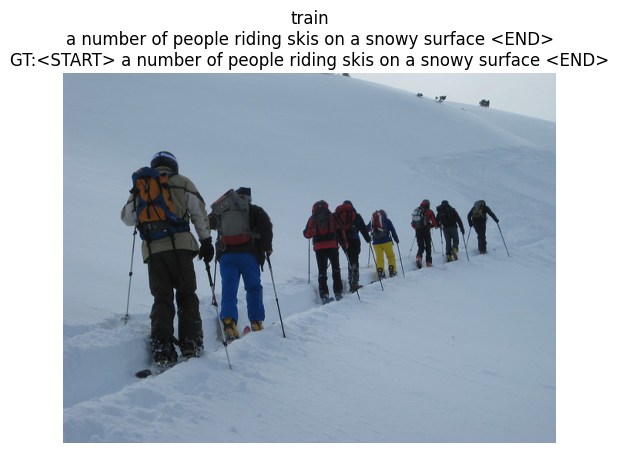

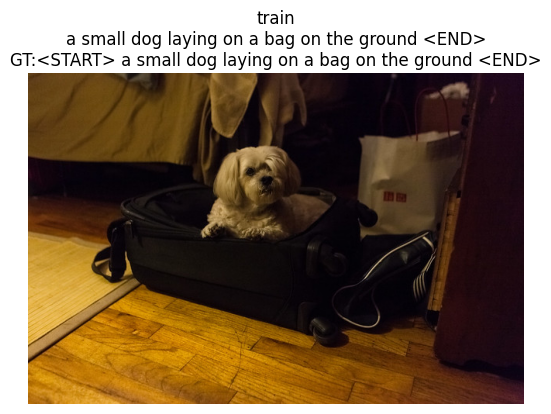

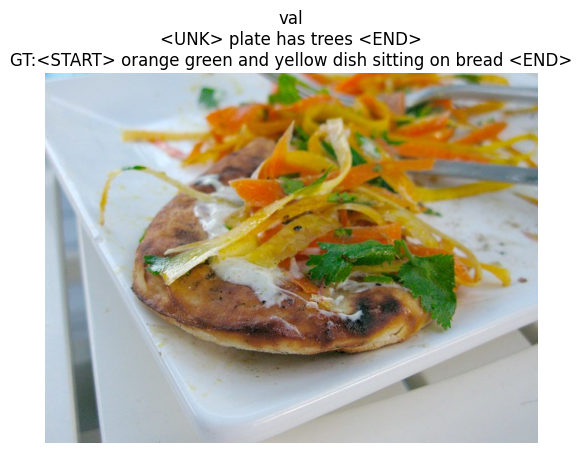

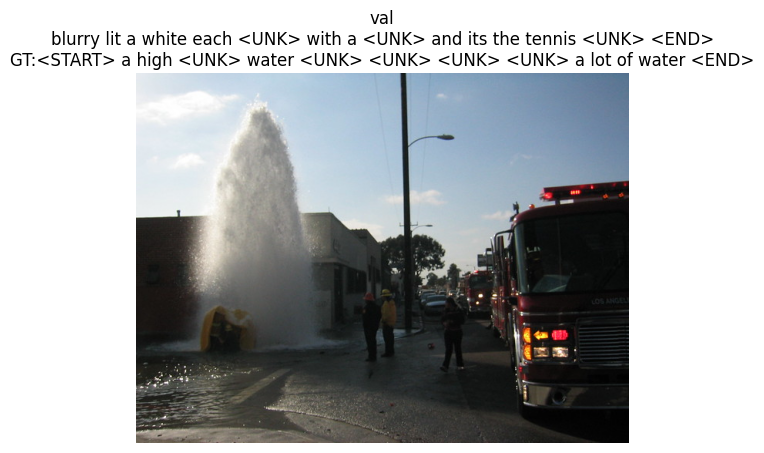

In [50]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)

        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()